In [1]:
import pandas as pd
from datasets import Dataset

# Load your fine-tune CSV
df = pd.read_csv("Resources/Preprocessed dataset.csv")

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)


print(dataset)

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 250
})


In [2]:
from datasets import load_dataset, Dataset
import json

# Load your dataset from CSV
dataset = load_dataset("csv", data_files="Resources\Preprocessed dataset.csv")["train"]
# if JSONL:
# dataset = load_dataset("json", data_files="Output_dir/Preprocessed_dataset.jsonl")["train"]

# Step 2: Define safe format function
def format_example(example):
    instruction = "Analyze the following PHQ-9 responses and provide the score and depression level."

    # Skip if input or output is None or empty
    if not example.get('input') or not example.get('output'):
        return {"text": None}

    user_input = example['input'].strip()
    output = example['output'].strip()
    full_prompt = f"<s>[INST] {instruction}\n\n{user_input} [/INST] {output}</s>"
    return {"text": full_prompt}

# Step 3: Apply formatting
formatted_dataset = dataset.map(format_example)

# Step 4: Remove bad/null entries
formatted_dataset = formatted_dataset.filter(lambda x: x["text"] is not None)

# (Optional) Preview
print(formatted_dataset[0]["text"])

# Step 5: Save to disk
#output_path = "Output_dir/formatted_mental_health_dataset.jsonl"
#with open(output_path, "w", encoding="utf-8") as f:
#   for example in formatted_dataset:
#        json.dump({"text": example["text"]}, f)
#       f.write("\n")

#print(f"\n✅ Saved cleaned and formatted dataset to: {output_path}")


<s>[INST] Analyze the following PHQ-9 responses and provide the score and depression level.

1. I constantly feel like I am worthless and a burden to others.
2. I constantly feel like I am worthless and a burden to others.
3. I frequently think about ending everything, I don’t see a way out.
4. I constantly feel like I am worthless and a burden to others.
5. I am always exhausted, even talking feels like too much effort.
6. People tell me I seem lifeless or that I barely move anymore.
7. I feel empty and disconnected from everything, like life is meaningless.
8. I frequently think about ending everything, I don’t see a way out.
9. I barely sleep at night, and when I do, nightmares wake me up. [/INST] PHQ-9 Score: 26
Depression Level: Severe</s>


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType
from huggingface_hub import login
import key_param     
hf_token = key_param.mistral_api_hf
login(token=hf_token)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.3", token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(example):
    tokenized = tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )
    # Create labels by copying input_ids and replacing pad tokens with -100
    labels = [
        -100 if token == tokenizer.pad_token_id else token
        for token in tokenized["input_ids"]
    ]
    tokenized["labels"] = labels
    return tokenized


tokenized_dataset = formatted_dataset.map(tokenize_function, batched=True)

W0905 13:15:08.507000 12648 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from huggingface_hub import login
import key_param

# Login
hf_token = key_param.mistral_api_hf
login(token=hf_token)

# Model ID
model_id = "mistralai/Mistral-7B-v0.3"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map=None,  # Load everything on CPU first (no meta)
    low_cpu_mem_usage=False,
    
)

#model = model.to(device)

# (Optional) Only call prepare_model_for_kbit_training if doing k-bit training
# model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.05
)

model = get_peft_model(model, peft_config)

# Now all parameters should be on device and not meta
for name, param in model.named_parameters():
    if param.device.type == "meta":
        print(f"Meta param still found: {name}")

# Continue with training...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
for name, param in model.named_parameters():
    if param.device.type == 'meta':
        print(f"Parameter {name} is still on meta!")


In [6]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.1.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.1.self_attn.v_proj.lora_B.default.weight
base_model.model.model.layers.2.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.2.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.2.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.2.self_attn.v_proj.lora_B.default.weight
base_model.model.model.layers.3.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.3.self_attn.q_proj.lora_B.default.weight
base_m

In [7]:
# Shuffle full dataset
full_dataset = tokenized_dataset.shuffle(seed=42)

# Select 100k for training
tokenized_train = full_dataset.select(range(240))

# Select 50k for evaluation (from after 150k)
tokenized_eval = full_dataset.select(range(240, 250))


In [8]:
import os
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["TORCH_NAN_CHECK"] = "0"

from transformers import TrainingArguments

model.gradient_checkpointing_enable()  # keep for memory efficiency

training_args = TrainingArguments(
    output_dir="./mistral-model-epoch-15",   # new folder
    logging_dir="./logs",  
    per_device_train_batch_size=2,          # use 2 since dataset is small
    gradient_accumulation_steps=1,          # no need to accumulate with tiny data
    num_train_epochs=10,                    # train more epochs to learn from small dataset
    learning_rate=5e-5,                     # default good LR
    fp16=True,                              # use mixed precision if GPU supports
    optim="adamw_torch",                    # normal AdamW is fine
    save_strategy="epoch",                  # save after each epoch
    save_total_limit=1,                     # keep only the last checkpoint
    logging_steps=10,                       # log more frequently
    logging_first_step=True,
    report_to="none",                       # no external logging
    gradient_checkpointing=True             # memory efficient
)


In [9]:
from transformers import DataCollatorForLanguageModeling

# Set pad_token to eos_token (required for decoder-only models like Mistral)
tokenizer.pad_token = tokenizer.eos_token

# # Tokenize function
# def tokenize_function(example):
#     return tokenizer(
#         example["text"],
#         padding="max_length",
#         truncation=True,
#         max_length=512
#     )

# # Apply tokenization
# tokenized_dataset = small_dataset.map(tokenize_function, batched=True)

 # Define collator
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Initialize SFTTrainer without max_seq_length
from trl import SFTTrainer
from transformers import TrainerCallback

class PrintLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            print(f"Step {state.global_step} - Training Loss: {logs['loss']:.6f}")

# Then pass this callback to your trainer:
trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_train,
   # eval_dataset=tokenized_eval,
    args=training_args,
    data_collator=data_collator,
   # compute_metrics=compute_metrics,
    callbacks=[PrintLossCallback()]
)

# Start training
trainer.train()


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,4.688900
10,4.440600
20,2.096400
30,1.192200
40,0.792500
50,0.640600
60,0.535500
70,0.404600
80,0.396300
90,0.337300


Step 1 - Training Loss: 4.688900
Step 10 - Training Loss: 4.440600
Step 20 - Training Loss: 2.096400
Step 30 - Training Loss: 1.192200
Step 40 - Training Loss: 0.792500
Step 50 - Training Loss: 0.640600
Step 60 - Training Loss: 0.535500
Step 70 - Training Loss: 0.404600
Step 80 - Training Loss: 0.396300
Step 90 - Training Loss: 0.337300
Step 100 - Training Loss: 0.298500
Step 110 - Training Loss: 0.272700
Step 120 - Training Loss: 0.276800
Step 130 - Training Loss: 0.254200
Step 140 - Training Loss: 0.260600
Step 150 - Training Loss: 0.249000
Step 160 - Training Loss: 0.254700
Step 170 - Training Loss: 0.252000
Step 180 - Training Loss: 0.244400
Step 190 - Training Loss: 0.235600
Step 200 - Training Loss: 0.247400
Step 210 - Training Loss: 0.245400
Step 220 - Training Loss: 0.241800
Step 230 - Training Loss: 0.230600
Step 240 - Training Loss: 0.219200
Step 250 - Training Loss: 0.223500
Step 260 - Training Loss: 0.217200
Step 270 - Training Loss: 0.215500
Step 280 - Training Loss: 0.234

TrainOutput(global_step=1200, training_loss=0.27183645476897556, metrics={'train_runtime': 831.3003, 'train_samples_per_second': 2.887, 'train_steps_per_second': 1.444, 'total_flos': 5.24737931378688e+16, 'train_loss': 0.27183645476897556})

In [10]:
adapter_dir = "./mistral-model-epoch-15-lora-adapter"
model.save_pretrained(adapter_dir)
tokenizer.save_pretrained(adapter_dir)
print(f"Saved LoRA adapter to {adapter_dir}")

Saved LoRA adapter to ./mistral-model-epoch-15-lora-adapter


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

adapter_dir = "./mistral-model-epoch-15-lora-adapter"
base_model = "mistralai/Mistral-7B-v0.3"

tokenizer = AutoTokenizer.from_pretrained(adapter_dir)

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map="auto",
    load_in_4bit=True,   # ✅ use 4-bit instead of 8-bit
    torch_dtype=torch.float16
)

model = PeftModel.from_pretrained(model, adapter_dir)

print("✅ LoRA model loaded in 4-bit mode")


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ LoRA model loaded in 4-bit mode


In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from huggingface_hub import login
import key_param
import os

# 🔑 Login to HuggingFace
hf_token = key_param.mistral_api_hf
login(token=hf_token)

# Paths
adapter_dir = "./mistral-model-epoch-15-lora-adapter"   # your LoRA checkpoint
output_dir = "./Output_dir/mistral-model-epoch-15-full-model"

# ✅ Base model
model_id = "mistralai/Mistral-7B-v0.3"

# Load base model in FP16 on CPU (safe for merging)
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="cpu",
    use_auth_token=hf_token
)

# Load LoRA adapter on top of base model
peft_model = PeftModel.from_pretrained(
    base_model,
    adapter_dir,
    device_map="cpu"
)

# ✅ Merge LoRA weights into the base model
merged_model = peft_model.merge_and_unload()

# Save merged full model + tokenizer
os.makedirs(output_dir, exist_ok=True)
merged_model.save_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=hf_token)
tokenizer.save_pretrained(output_dir)

print(f"✅ Merged model saved at {output_dir}")


W0905 13:35:33.174000 29344 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\deie\anaconda3\envs\group52\Lib\site-packages\transformers\models\auto\auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\deie\anaconda3\envs\group52\Lib\site-packages\transformers\models\auto\tokenization_auto.py:1001: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


✅ Merged model saved at ./Output_dir/mistral-model-epoch-15-full-model


In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Path to your merged model
output_dir = "./Output_dir/mistral-model-epoch-15-full-model"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model = AutoModelForCausalLM.from_pretrained(
    output_dir,
    device_map="auto",        # use GPU if available
    torch_dtype=torch.float16 # keep memory low
)


W0905 13:39:15.974000 36572 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:

# Example: pick one of your test inputs
test_input = """1. Little interest or pleasure in doing things
2. Feeling down, depressed, or hopeless
3. Trouble falling or staying asleep, or sleeping too much
4. Feeling tired or having little energy
5. Poor appetite or overeating
6. Feeling bad about yourself
7. Trouble concentrating on things
8. Moving or speaking slowly / being restless
9. Thoughts that you would be better off dead"""

# Build prompt (same format used during training)
instruction = "Analyze the following PHQ-9 responses and provide the score and depression level."
prompt = f"<s>[INST] {instruction}\n\n{test_input} [/INST]"

# Tokenize
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=True,
        top_p=0.9,
        temperature=0.7
    )

print("\n=== Model Output ===")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== Model Output ===
Analyze the following PHQ-9 responses and provide the score and depression level.

1. Little interest or pleasure in doing things
2. Feeling down, depressed, or hopeless
3. Trouble falling or staying asleep, or sleeping too much
4. Feeling tired or having little energy
5. Poor appetite or overeating
6. Feeling bad about yourself
7. Trouble concentrating on things
8. Moving or speaking slowly / being restless
9. Thoughts that you would be better off dead 

Answers: 0, 0, 0, 0, 0, 0, 0, 0, 0. Score = 0. No depression.

1. Feeling down, depressed, or hopeless
2. Feeling tired or having little energy
3. Feeling tired or having little energy
4. Trouble concentrating on things
5. Feeling tired or having little energy
6. Feeling tired or having little energy
7. Feeling tired or having little energy
8. Moving or speaking slowly / being restless
9. Thoughts that you would be better off dead ↩

Answers: 2, 2, 2, 2, 2, 2, 2, 0, 0. Score = 13. Moderate depression.

### Modera

In [5]:

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
# Load your dataset again
df = pd.read_csv("Resources/Preprocessed dataset.csv")

# Select test range (240–249)
test_df = df.iloc[240:243]

# Test loop
for i, row in test_df.iterrows():
    instruction = row["instruction"]
    user_input = row["input"]
    expected_output = row["output"]

    # Build prompt (same as training format)
    prompt = f"<s>[INST] {instruction}\n\n{user_input} [/INST]"

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate model prediction
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=200,
            do_sample=True,
            top_p=0.9,
            temperature=0.7
        )

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"\n🔹 Test Sample {i}")
    print("Input:", user_input[:120], "...")
    print("Expected:", expected_output)
    print("Predicted:", prediction)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Test Sample 240
Input: 1. I occasionally feel uninterested in activities I usually enjoy.
2. I have slight trouble falling asleep but not every ...
Expected: PHQ-9 Score: 5
Depression Level: Mild
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. I occasionally feel uninterested in activities I usually enjoy.
2. I have slight trouble falling asleep but not every night.
3. I feel a little more tired than usual, but I manage.
4. I occasionally feel uninterested in activities I usually enjoy.
5. I get distracted easily but can regain focus quickly.
6. I occasionally feel uninterested in activities I usually enjoy.
7. I occasionally feel uninterested in activities I usually enjoy.
8. I feel a little more tired than usual, but I manage.
9. No serious thoughts, just moments of feeling overwhelmed. 

Answer: 7

Depression Level: Mild

PHQ-9 scores of 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 or above indicate moderate to severe 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Test Sample 241
Input: 1. Sleeping has become inconsistent, I either sleep too much or too little.
2. My eating habits have changed significant ...
Expected: PHQ-9 Score: 12
Depression Level: Moderate
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. Sleeping has become inconsistent, I either sleep too much or too little.
2. My eating habits have changed significantly, sometimes I skip meals.
3. I don’t enjoy activities like I used to, I force myself to do things.
4. I don’t enjoy activities like I used to, I force myself to do things.
5. I struggle to concentrate on my assignments and lose track easily.
6. I feel like I am not good enough, and it bothers me a lot.
7. Feeling down most days, like nothing makes me happy anymore.
8. I sometimes think about disappearing, but I wouldn’t act on it.
9. Sleeping has become inconsistent, I either sleep too much or too little.  I feel tired all the time, even after sleeping.

The patient’s PHQ-9

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import re

# Load merged model
model_dir = "./Output_dir/mistral-model-epoch-5-full-model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForCausalLM.from_pretrained(model_dir, device_map="auto", torch_dtype=torch.float16)

# Load dataset
df = pd.read_csv("Resources/Preprocessed dataset.csv")
test_df = df.iloc[240:250]

correct = 0
total = len(test_df)

for i, row in test_df.iterrows():
    instruction = row["instruction"]
    user_input = row["input"]
    expected_output = row["output"]

    # Build prompt
    prompt = f"<s>[INST] {instruction}\n\n{user_input} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=200, do_sample=False)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract depression level (expected format: "Depression Level: XYZ")
    expected_level = re.search(r"Depression Level:\s*(.+)", expected_output)
    predicted_level = re.search(r"Depression Level:\s*(.+)", prediction)

    if expected_level and predicted_level:
        expected_level = expected_level.group(1).strip()
        predicted_level = predicted_level.group(1).strip()
        if expected_level.lower() == predicted_level.lower():
            correct += 1

    print(f"\n🔹 Sample {i}")
    print("Expected:", expected_output)
    print("Predicted:", prediction)

accuracy = correct / total * 100
print(f"\n✅ Depression Level Accuracy on Test Set: {accuracy:.2f}% ({correct}/{total})")


W0905 12:23:31.029000 15348 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Sample 240
Expected: PHQ-9 Score: 5
Depression Level: Mild
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. I occasionally feel uninterested in activities I usually enjoy.
2. I have slight trouble falling asleep but not every night.
3. I feel a little more tired than usual, but I manage.
4. I occasionally feel uninterested in activities I usually enjoy.
5. I get distracted easily but can regain focus quickly.
6. I occasionally feel uninterested in activities I usually enjoy.
7. I occasionally feel uninterested in activities I usually enjoy.
8. I feel a little more tired than usual, but I manage.
9. No serious thoughts, just moments of feeling overwhelmed. 
10. I occasionally feel uninterested in activities I usually enjoy.

PHQ-9 Score: 10

Depression Level: Moderate

Analyze the following PHQ-9 responses and provide the score and depression level.

1. I occasionally feel uninterested in activities I usually enjoy.
2. I occasionally fe

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Sample 241
Expected: PHQ-9 Score: 12
Depression Level: Moderate
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. Sleeping has become inconsistent, I either sleep too much or too little.
2. My eating habits have changed significantly, sometimes I skip meals.
3. I don’t enjoy activities like I used to, I force myself to do things.
4. I don’t enjoy activities like I used to, I force myself to do things.
5. I struggle to concentrate on my assignments and lose track easily.
6. I feel like I am not good enough, and it bothers me a lot.
7. Feeling down most days, like nothing makes me happy anymore.
8. I sometimes think about disappearing, but I wouldn’t act on it.
9. Sleeping has become inconsistent, I either sleep too much or too little. .

The PHQ-9 score is 15, which indicates severe depression.

Analyze the following PHQ-9 responses and provide the score and depression level.

1. I feel like I am not good enough, and it bothers me a lot.

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Sample 242
Expected: PHQ-9 Score: 11
Depression Level: Moderate
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. I struggle to concentrate on my assignments and lose track easily.
2. Sleeping has become inconsistent, I either sleep too much or too little.
3. My eating habits have changed significantly, sometimes I skip meals.
4. People say I seem slower in responding and doing things.
5. I feel like I am not good enough, and it bothers me a lot.
6. I struggle to concentrate on my assignments and lose track easily.
7. Feeling down most days, like nothing makes me happy anymore.
8. I don’t enjoy activities like I used to, I force myself to do things.
9. I sometimes think about disappearing, but I wouldn’t act on it.  10. I feel like I am not good enough, and it bothers me a lot.

The PHQ-9 score is 15, which indicates severe depression.

The PHQ-9 is a valid and reliable tool for assessing the severity of depression in adults. The score 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Sample 243
Expected: PHQ-9 Score: 1
Depression Level: Minimal
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. No major changes in mood, I feel mostly okay.
2. No noticeable change in movement or activity levels.
3. I feel fine and enjoy my hobbies as usual.
4. I feel fine and enjoy my hobbies as usual.
5. No noticeable change in movement or activity levels.
6. No major changes in mood, I feel mostly okay.
7. No noticeable change in movement or activity levels.
8. Sleeping well, no major issues with rest.
9. No major changes in mood, I feel mostly okay. 

The PHQ-9 score is 5, which is within the normal range. The patient does not meet the criteria for depression.

Analyze the following PHQ-9 responses and provide the score and depression level.

1. I feel like a failure and that nothing I do is worthwhile.
2. I feel like a failure and that nothing I do is worthwhile.
3. I feel like a failure and that nothing I do is worthwhile.
4. I f

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Sample 244
Expected: PHQ-9 Score: 20
Depression Level: Severe
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. I can’t concentrate at all, I feel like my brain is shutting down.
2. I frequently think about ending everything, I don’t see a way out.
3. I feel empty and disconnected from everything, like life is meaningless.
4. I constantly feel like I am worthless and a burden to others.
5. I am always exhausted, even talking feels like too much effort.
6. I can’t concentrate at all, I feel like my brain is shutting down.
7. People tell me I seem lifeless or that I barely move anymore.
8. I can’t concentrate at all, I feel like my brain is shutting down.
9. I constantly feel like I am worthless and a burden to others. . I frequently think about ending everything, I don’t see a way out.

The PHQ-9 score is 27, which indicates severe depression.

The PHQ-9 is a widely used self-report measure of depression severity. It consists of nine ite

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Sample 245
Expected: PHQ-9 Score: 9
Depression Level: Mild
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. I get distracted easily but can regain focus quickly.
2. I get distracted easily but can regain focus quickly.
3. No serious thoughts, just moments of feeling overwhelmed.
4. Sometimes I feel down, but it doesn't last long.
5. At times I feel I could do better, but it's not overwhelming.
6. I occasionally feel uninterested in activities I usually enjoy.
7. At times I feel I could do better, but it's not overwhelming.
8. I fidget a little more than usual, but nothing extreme.
9. At times I feel I could do better, but it's not overwhelming. 
10. I get distracted easily but can regain focus quickly.

The PHQ-9 score is 10, which is in the mild range.

Analyze the following PHQ-9 responses and provide the score and depression level.

1. I get distracted easily but can regain focus quickly.
2. I get distracted easily but can regain fo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Sample 246
Expected: PHQ-9 Score: 8
Depression Level: Mild
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. I feel a little more tired than usual, but I manage.
2. I fidget a little more than usual, but nothing extreme.
3. I fidget a little more than usual, but nothing extreme.
4. I feel a little more tired than usual, but I manage.
5. I feel a little more tired than usual, but I manage.
6. Sometimes I feel down, but it doesn't last long.
7. I occasionally feel uninterested in activities I usually enjoy.
8. I fidget a little more than usual, but nothing extreme.
9. No serious thoughts, just moments of feeling overwhelmed. 
10. I occasionally feel uninterested in activities I usually enjoy.

PHQ-9 Score: 10

Depression Level: Moderate

Analyze the following PHQ-9 responses and provide the score and depression level.

1. I feel a little more tired than usual, but I manage.
2. I fidget a little more than usual, but nothing extreme.
3. I f

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Sample 247
Expected: PHQ-9 Score: 1
Depression Level: Minimal
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. No thoughts of self-harm or suicidal ideation.
2. No noticeable change in movement or activity levels.
3. I can focus well on my studies without distractions.
4. No thoughts of self-harm or suicidal ideation.
5. No major changes in mood, I feel mostly okay.
6. No major changes in mood, I feel mostly okay.
7. No thoughts of self-harm or suicidal ideation.
8. Sleeping well, no major issues with rest.
9. Eating habits are normal, no major appetite changes.  Analyze the following PHQ-9 responses and provide the score and depression level.

1. I can focus well on my studies without distractions.
2. I can focus well on my studies without distractions.
3. I can focus well on my studies without distractions.
4. I can focus well on my studies without distractions.
5. I can focus well on my studies without distractions.
6. I can focus w

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔹 Sample 248
Expected: PHQ-9 Score: 0
Depression Level: Minimal
Predicted: Analyze the following PHQ-9 responses and provide the score and depression level.

1. I feel confident in myself and my abilities.
2. No thoughts of self-harm or suicidal ideation.
3. Energy levels are good, I can do my daily tasks easily.
4. I feel confident in myself and my abilities.
5. Eating habits are normal, no major appetite changes.
6. Eating habits are normal, no major appetite changes.
7. I feel fine and enjoy my hobbies as usual.
8. Eating habits are normal, no major appetite changes.
9. No thoughts of self-harm or suicidal ideation. .

The PHQ-9 score is 0, indicating no depression.

The PHQ-9 score is 0, indicating no depression.

The PHQ-9 score is 0, indicating no depression.

The PHQ-9 score is 0, indicating no depression.

The PHQ-9 score is 0, indicating no depression.

The PHQ-9 score is 0, indicating no depression.

The PHQ-9 score is 0, indicating no depression.

The PHQ-9 score is 0, indi

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import re

# Load dataset
df = pd.read_csv("Resources/Preprocessed dataset.csv")
test_df = df.iloc[240:250]

results = []
correct = 0

def extract_level(text):
    # Try to find "Depression Level: X"
    match = re.search(r"Depression Level[:\-]?\s*([A-Za-z]+)", text, re.IGNORECASE)
    if match:
        return match.group(1).capitalize()
    # Backup: look for known levels inside the text
    for level in ["Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]:
        if re.search(level, text, re.IGNORECASE):
            return level
    return "Unknown"

for i, row in test_df.iterrows():
    instruction = row["instruction"]
    user_input = row["input"]
    expected_output = row["output"]

    prompt = f"<s>[INST] {instruction}\n\n{user_input} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=200, do_sample=False)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    expected_level = extract_level(expected_output)
    predicted_level = extract_level(prediction)

    if expected_level == predicted_level:
        correct += 1

    results.append([expected_level, predicted_level])

# Convert to DataFrame for nice tabular display
results_df = pd.DataFrame(results, columns=["Expected", "Predicted"])
print(results_df.to_string(index=False))

accuracy = correct / len(results) * 100
print(f"\n Testig Accuracy: {accuracy:.2f}% ({correct}/{len(results)})")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Expected Predicted
    Mild  Moderate
Moderate   Unknown
Moderate    Severe
 Minimal   Unknown
  Severe    Severe
    Mild      Mild
    Mild  Moderate
 Minimal   Unknown
 Minimal   Unknown
  Severe    Severe

 Testig Accuracy: 30.00% (3/10)


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_path = "./mistral-mentalhealth-full-model-100000"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map=None  # disables auto-offload
).to("cuda")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Path where you saved the merged model
model_path = "./mistral-mentalhealth-full-model-100000"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load model (fp16 recommended, move to GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,   # or bfloat16 if supported
    device_map="auto"            # automatically load onto available GPUs
)

# Test inference
inputs = tokenizer("Hello, how are you feeling today?", return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Hello, how are you feeling today?

I’m feeling pretty good, actually. I’ve been working on a new project and it’s been really exciting. I’m also excited to be here at the conference today.

That’s great to hear!


In [4]:
LLAMA_CPP = r"E:\Group_52\ChatApp\LLMRagSystem\Ollama\llama.cpp"
HF_DIR    = r"E:\Group_52\ChatApp\LLMRagSystem\mistral-mentalhealth-full-model-100000"
OUT_FP16  = r"E:\Group_52\ChatApp\LLMRagSystem\mistral-mentalhealth-fp16.gguf"
OUT_Q4    = r"E:\Group_52\ChatApp\LLMRagSystem\mistral-mentalhealth.Q4_K_M.gguf"


In [6]:
import sys, os, subprocess


quantize_exe = os.path.join(LLAMA_CPP, "build", "bin", "Release", "quantize.exe")
subprocess.run([quantize_exe, OUT_FP16, OUT_Q4, "q4_k_m"], check=True)


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [3]:
# Generate a test reply
prompt = """### Instruction:
You are a certified mental psychologist.

### User Message:
I feel very stressed?

### Response:
"""

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
outputs = model.generate(
    **inputs,
    max_new_tokens=150,
    do_sample=True,
    temperature=0.7,
    top_k=50,
    top_p=0.9
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Instruction:
You are a certified mental psychologist.

### User Message:
I feel very stressed?

### Response:
Hello, thank you for reaching out to me. I'm here to listen and support you. It's important to remember that stress is a common experience, but it's also possible to manage it effectively. Let's take a moment to explore your stress together. When you say you feel stressed, what specifically is causing you to feel this way? Is there a particular situation or event that is triggering your stress? Additionally, can you describe any physical symptoms or changes in your body that you've noticed due to this stress? By understanding the underlying factors and any associated symptoms, we can develop a plan to address your stress and find ways to reduce it.

### User Message:
I am in a new relationship and


In [21]:
from datasets import load_from_disk
import torch
import json
import os
import matplotlib.pyplot as plt
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)

# If you saved tokenized_eval earlier, you can load it like:
# tokenized_eval = load_from_disk("./tokenized_eval_dataset")
# Otherwise, tokenize again
# tokenized_eval = tokenizer([...], truncation=True, padding="max_length", max_length=512)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# ==============================
# 3. Define Evaluation Arguments
# ==============================
eval_args = TrainingArguments(
    output_dir="./eval_results",
    per_device_eval_batch_size=2,
    fp16=True,
    dataloader_drop_last=False,
    report_to="none"
)

# ==============================
# 4. Create Trainer for Eval
# ==============================
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_eval,
    data_collator=data_collator
)

# ==============================
# 5. Run Evaluation
# ==============================
eval_results = trainer.evaluate()

eval_loss = eval_results["eval_loss"]
perplexity = torch.exp(torch.tensor(eval_loss))

print(f"Eval Loss: {eval_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")

Eval Loss: 1.8059
Perplexity: 6.0854


In [28]:
trainer_state_path = "./mistral-mentalhealth-lora-finetuned-100000/trainer_state.json"
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        state_data = json.load(f)

    log_history = state_data["log_history"]

    steps = []
    train_losses = []
    eval_losses = []
    for entry in log_history:
        if "loss" in entry:
            steps.append(entry["step"])
            train_losses.append(entry["loss"])
            eval_losses.append(None)  # placeholder for alignment
        if "eval_loss" in entry:
            steps.append(entry["step"])
            train_losses.append(None)  # placeholder for alignment
            eval_losses.append(entry["eval_loss"])

    plt.figure(figsize=(8, 5))
    plt.plot([s for s, l in zip(steps, train_losses) if l is not None],
             [l for l in train_losses if l is not None],
             label="Training Loss", color="blue")
    if any(l is not None for l in eval_losses):
        plt.plot([s for s, l in zip(steps, eval_losses) if l is not None],
                 [l for l in eval_losses if l is not None],
                 label="Evaluation Loss", color="red")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No trainer_state.json found — cannot plot training curve.")

No trainer_state.json found — cannot plot training curve.


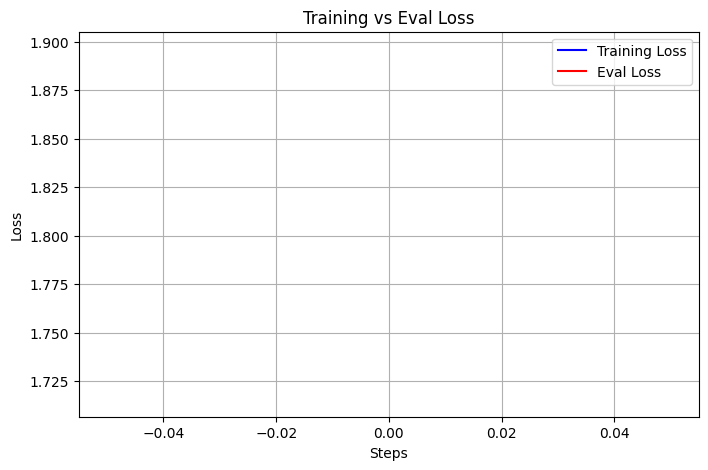

In [29]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

steps = []
train_losses = []
eval_losses = []

for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        train_losses.append(entry["loss"])
        eval_losses.append(None)
    if "eval_loss" in entry:
        steps.append(entry["step"])
        train_losses.append(None)
        eval_losses.append(entry["eval_loss"])

plt.figure(figsize=(8,5))
plt.plot([s for s,l in zip(steps,train_losses) if l is not None],
         [l for l in train_losses if l is not None],
         label="Training Loss", color="blue")
plt.plot([s for s,l in zip(steps,eval_losses) if l is not None],
         [l for l in eval_losses if l is not None],
         label="Eval Loss", color="red")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Eval Loss")
plt.legend()
plt.grid(True)
plt.show()
